# Example on the urban canopy data 

In [15]:
from pivpy import io, graphics, pivpy
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pkg_resources as pkg
%matplotlib inline

In [28]:
from lvreader import read_buffer
import pathlib
filename = pathlib.Path(pkg.resource_filename('pivpy','data/urban_canopy/B00001.vc7'))
# import pathlib
# vc7file = pathlib.Path('../../pivpy/data/VC7/2d2c/2Ca.vc7')
buffer = read_buffer(str(filename))
# print(buffer)

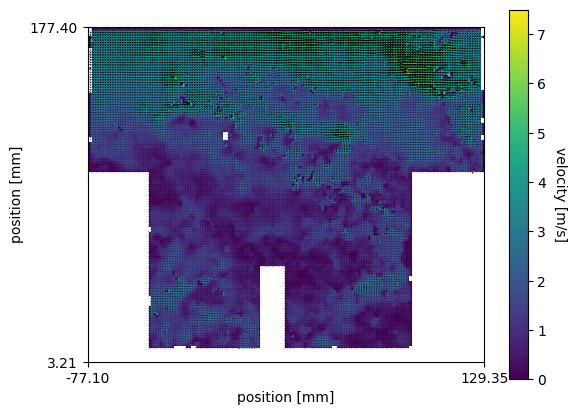

In [29]:
buffer.plot()

In [30]:
ds = io.load_vc7(filename)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'t = 0 [frame]'}, xlabel='x (pix)', ylabel='y (pix)'>)

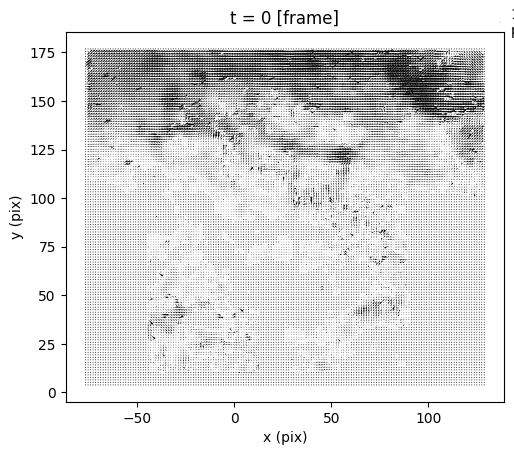

In [31]:
graphics.quiver(ds.isel(t=-1),arrScale=50) # show last

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='x (pix)', ylabel='y (pix)'>)

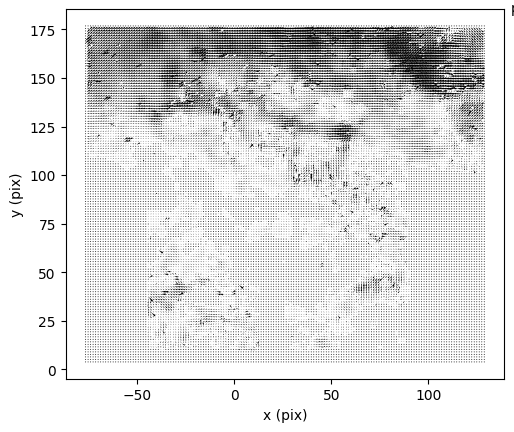

In [34]:
graphics.quiver(ds.piv.average,arrScale=50)

In [ ]:
# Let's try vertical profile of streamwise mean velocity U(z)
# we could define it a shortcut of the type:
# graphics.profile(velocity_component = 'u', coordinate = 'z') 
plt.plot(data.mean(dim='x').mean(dim='t').u,data.y)
plt.xlabel('U (m/s)')
plt.ylabel('z (mm)')

In [ ]:
graphics.quiver(data[dict(y=slice(100, 175))])
# something strange with the mask

In [ ]:
# let's test homogeneity above the canopy: 
# take y above some value and .mean(dim='y')
# take mean with time .mean(dim='t')
# plot:
data.where(data.y>120,drop=True).mean(dim='t').mean(dim='y').u.plot()
data.where(data.y>150,drop=True).mean(dim='t').mean(dim='y').u.plot()

In [ ]:
data.where((data.x > -40) & (data.x < 0), drop=True).mean(dim='t').u.mean(dim='x').plot()
data.where((data.x > 20) & (data.x < 80), drop=True).mean(dim='t').u.mean(dim='x').plot()

In [ ]:
graphics.quiver(data.where(data.y>100,drop=True).mean(dim='t'),units=['mm','mm','m/s','m/s'],arrScale=500)

In [ ]:
# and some cool plot of average TKE above the canopy 
graphics.contour_plot(data.piv.tke().mean(dim='t').where(data.y > 100,drop=True),units=data.attrs['units'])